## Import packages

In [ ]:
import torch
import time
import cortex
import numpy as np
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import gridspec
from voxelwise_tutorials.utils import generate_leave_one_run_out
from voxelwise_tutorials.delayer import Delayer
from sklearn import set_config
from sklearn.model_selection import LeaveOneOut, check_cv
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score as r2

from sklearn.decomposition import PCA 

from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore, pearsonr, ttest_1samp, spearmanr, kendalltau, ttest_rel, f_oneway
from nltools.stats import isc, fdr, fisher_r_to_z, norm
from nltools.external import hrf
from nilearn.glm import threshold_stats_img
from statsmodels.stats.multitest import fdrcorrection
from himalaya.kernel_ridge import KernelRidgeCV, MultipleKernelRidgeCV, ColumnKernelizer, Kernelizer
from himalaya.viz import plot_alphas_diagnostic
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV, GroupRidgeCV, ColumnTransformerNoStack
from himalaya.scoring import r2_score_split, correlation_score_split, r2_score, correlation_score, r2_score_split_svd
from multiprocessing import Pool

from util_func import *

result_folder = 'path_files'

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
np.set_printoptions(precision=6, suppress=True)

roi_mask = nib.load(f'{result_folder}/BNA_3mm_atlas.nii.gz').get_fdata()
brain_mask = nib.load(f'{result_folder}/MNI152NLin2009cAsym_3mm_mask.nii.gz').get_fdata()

gm_idx = np.where(roi_mask[brain_mask > 0] > 0)[0]
wm_idx = np.where(roi_mask[brain_mask > 0] == 0)[0]

## Load all data

In [4]:
aa = np.ones((6,6))
aa[np.diag_indices(6)] = 0
aa = aa.astype('bool')

excluded_tr_ep1 = np.concatenate([np.arange(10)])
excluded_tr_ep2 = np.concatenate([np.arange(44)])
excluded_tr_ep3 = np.concatenate([np.arange(44)])

rest_tr_ep1 = np.delete(np.arange(996), excluded_tr_ep1)
rest_tr_ep2 = np.delete(np.arange(958), excluded_tr_ep2)
rest_tr_ep3 = np.delete(np.arange(710), excluded_tr_ep3)
rest_total = rest_tr_ep1.shape[0] + rest_tr_ep2.shape[0] + rest_tr_ep3.shape[0]

hrf_delay = 0
rest_tr_for_feature = np.hstack([rest_tr_ep1, rest_tr_ep2+996, rest_tr_ep3+996+958])
rest_tr_for_neural = np.hstack([rest_tr_ep1, rest_tr_ep2+996, rest_tr_ep3+996+958])
print(f'{rest_tr_ep1.shape[0]} + {rest_tr_ep2.shape[0]} + {rest_tr_ep3.shape[0]} = {rest_total}')

sub_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10', 'sub-11', 'sub-12', 'sub-13', 'sub-14', 
            'sub-15', 'sub-16', 'sub-17', 'sub-18', 'sub-19', 'sub-20', 'sub-21', 'sub-22', 'sub-23', 'sub-24', 'sub-25', 'sub-26', 'sub-27', 'sub-28']

986 + 914 + 666 = 2566


In [ ]:
a = np.ones((6,6))
a[np.diag_indices(6)] = 0
a = a.astype('bool')

moten_features = np.load(f'{result_folder}/moten_features.npy')
pca = PCA(n_components = 1000)
moten_pca = pca.fit(moten_features)
pc_80 = np.sum(np.cumsum(moten_pca.explained_variance_ratio_) < 0.8) + 1
moten_tranformed = moten_pca.transform(moten_features)[:,:pc_80]

features1 = np.load(f'{result_folder}/TR_cooccur.npy', allow_pickle = True)
features1 = np.array([features1[t,a] for t in range(2664)])
features2 = np.load(f'{result_folder}/TR_cooccur.npy', allow_pickle = True)
features2 = np.array([features2[t,a] for t in range(2664)])
features3 = np.load(f'{result_folder}/TR_senti_pos.npy', allow_pickle = True)
features3 = np.array([features3[t,a] for t in range(2664)])
features4 = np.load(f'{result_folder}/TR_senti_neg.npy', allow_pickle = True)
features4 = np.array([features4[t,a] for t in range(2664)])

for r in range(30):
    if np.sum(features3[:,r]) != 0:
        features3[:,r][features3[:,r] < np.percentile(features3[:,r][features3[:,r] > 0], 100/3)] = 0
for r in range(30):
    if np.sum(features4[:,r]) != 0:
        features4[:,r][features4[:,r] > np.percentile(features4[:,r][features4[:,r] < 0], 200/3)] = 0

features2[features3 > 0] = 0
features2[features4 < 0] = 0

features1_gf5 = gaussian_filter1d(features1, 5, axis=0)
features2_gf5 = gaussian_filter1d(features2, 5, axis=0)
features3_gf5 = gaussian_filter1d(features3, 5, axis=0)
features4_gf5 = gaussian_filter1d(features4, 5, axis=0)

# features = np.hstack([features1, features2, features3, features4])
features = np.hstack([features1_gf5, features2_gf5, features3_gf5, features4_gf5])
# features = np.hstack([features1_gf5, features2_gf5, features3_gf5, features4_gf5, moten_tranformed])
features = features[rest_tr_for_feature,:]

social_movie_run = np.array([493,493,457,457,333,333])
onsets = np.cumsum(social_movie_run)
features_split = np.split(features, onsets, axis=0)

In [ ]:
brain_data_sc_sm = np.load(f'{result_folder}/fMRI_data/movie_data_ex1_s28_sc_sm.npy', allow_pickle = True)

## Voxelwise encoding modeling

### banded ridge

In [ ]:
# VEM
torch.manual_seed(2022)
np.random.seed(2022)

start = time.time()
set_config(display='diagram', assume_finite=True)

backend = set_backend("torch_cuda", on_error="warn")

feature_names = ["co-occurrence", "valence"]
# feature_names = ["co-occurrence", "valence", "motion_energy"]

n_iter = 20
alphas = np.logspace(0, 20, 41)

n_targets_batch = 10000
n_alphas_batch = 10
n_targets_batch_refit = 100 

r_scores_cv0 = []
r_scores_cv1 = []
r_scores_cv2 = []
weights = []
for sub in range(28):

    brain_split = np.split(brain_data_sc_sm[sub], onsets, axis=1)

    r_scores_batch0 = []
    r_scores_batch1 = []
    r_scores_batch2 = []
    weight = []
    for train_idx, test_idx in LeaveOneOut().split(range(len(social_movie_run))):
        train_run_onsets = np.cumsum([0]+social_movie_run[train_idx].tolist())[:-1]
        X_train = np.nan_to_num(np.vstack(([zscore(features_split[i], axis=0, nan_policy='omit') for i in train_idx])))
        X_train = np.vstack([np.convolve(X_train[:,i],hrf.glover_hrf(1,1)) for i in range(X_train.shape[1])])[:,:X_train.shape[0]].T
        X_test = np.nan_to_num(zscore(features_split[test_idx[0]], axis=0, nan_policy='omit'))
        X_test = np.vstack([np.convolve(X_test[:,i],hrf.glover_hrf(1,1)) for i in range(X_test.shape[1])])[:,:X_test.shape[0]].T

        y_train = np.hstack(([zscore(brain_split[i], axis=1, nan_policy='omit') for i in train_idx])).T
        y_test = zscore(brain_split[test_idx[0]], axis=1, nan_policy='omit').T
        
        n_features_list = [30, 90]
        # n_features_list = [30, 90, 50]
        n_features_list_cumsum = np.cumsum([0] + n_features_list)
        
        X_train = X_train.astype("float32")
        X_test = X_test.astype("float32")
        y_train = y_train.astype("float32")
        y_test = y_test.astype("float32")
        
        solver = "random_search"
        solver_function = GroupRidgeCV.ALL_SOLVERS[solver]

        n_samples_train = X_train.shape[0]
        cv = generate_leave_one_run_out(n_samples_train, train_run_onsets)
        cv = check_cv(cv)

        solver_params = dict(n_iter=n_iter, alphas=alphas,
                             n_targets_batch=n_targets_batch,
                             n_alphas_batch=n_alphas_batch,
                             n_targets_batch_refit=n_targets_batch_refit)
        
        mkr_model = GroupRidgeCV(groups="input", solver=solver,
                                 solver_params=solver_params, cv=cv)

        preprocess_pipeline = make_pipeline(
            StandardScaler(with_mean=True, with_std=False),
            Delayer(delays=[0]),
            )

        start_and_end = np.concatenate([[0], np.cumsum(n_features_list)])
        slices = [
            slice(start, end)
            for start, end in zip(start_and_end[:-1], start_and_end[1:])
        ]

        kernelizers_tuples = [(name, preprocess_pipeline, slice_)
                              for name, slice_ in zip(feature_names, slices)]
        
        column_kernelizer = ColumnTransformerNoStack(kernelizers_tuples)
        column_kernelizer

        pipeline = make_pipeline(
                        column_kernelizer,
                        mkr_model)

        pipeline.fit(X_train, y_train)

        y_test_pred_split = pipeline.predict(X_test, split=True)
        
        pred_y = pipeline.predict(X_test)
        pred_y = backend.to_numpy(pred_y)
        split_rscores = correlation_score_split(y_test, y_test_pred_split)
        
        r_scores_batch0.append(fisher_r_to_z(backend.to_numpy(correlation_score(y_test, pred_y))))
        r_scores_batch1.append(fisher_r_to_z(backend.to_numpy(split_rscores[0])))
        r_scores_batch2.append(fisher_r_to_z(backend.to_numpy(split_rscores[1])))
        
        weight.append(backend.to_numpy(pipeline.named_steps['groupridgecv'].coef_))
        torch.cuda.empty_cache()
        
    r_scores_cv0.append(np.nanmean(r_scores_batch0, axis=0))
    r_scores_cv1.append(np.nanmean(r_scores_batch1, axis=0))
    r_scores_cv2.append(np.nanmean(r_scores_batch2, axis=0))
    weights.append(weight)
r_scores_cv0 = np.array(r_scores_cv0)
r_scores_cv1 = np.array(r_scores_cv1)
r_scores_cv2 = np.array(r_scores_cv2)
weights = np.array(weights)
weights_mean = np.mean(weights, axis=1)

np.save(f'{result_folder}/VEM_f3_r_score0.npy',r_scores_cv0)
np.save(f'{result_folder}/VEM_f3_r_score1.npy',r_scores_cv1)
np.save(f'{result_folder}/VEM_f3_r_score2.npy',r_scores_cv2)
np.save(f'{result_folder}/ENCODING/VEM_f3_weights.npy',weights)

In [ ]:
# computing p-values
r_scores = np.load(f'{result_folder}/VEM_f3_r_score0.npy')

np.random.seed(2022)
data = r_scores
n_subjects = len(data)
observed_mean = np.nanmean(data, axis=0) 
bootstrap_means = []
n_bootstrap = 5000

for i in range(n_bootstrap):
    idxs = np.random.choice(n_subjects, size=n_subjects, replace=True)
    sample = data[idxs]
    boot_mean = np.nanmean(sample, axis=0)
    
    null_sample = boot_mean - observed_mean
    bootstrap_means.append(null_sample)

null_distribution = np.array(bootstrap_means)

p_values = np.mean(null_distribution >= observed_mean, axis=0)
np.save(f'{result_folder}/VEM_f3_p_value0.npy', p_values) 

## Recontruction of social relationships

In [ ]:
total_edge_DM = np.load(f'{result_folder}/total_edge_DM.npy')
total_personalities = np.load(f'{result_folder}/total_personalities.npy')

In [ ]:
weights = np.load(f'{result_folder}/VEM_f3_weights.npy')
weights_mean = np.mean(weights, axis=1)

cooccur_weight = weights_mean[:,:30,]
neutral_weight = weights_mean[:,30:60,:]
positive_weight = weights_mean[:,60:90,:]
negative_weight = weights_mean[:,90:,:]

# weights_mat = np.array([cooccur_weight]).transpose(1,3,0,2)
weights_mat = np.array([cooccur_weight, positive_weight, neutral_weight, negative_weight]).transpose(1,3,0,2)

aa = np.ones((6,6))
aa[np.diag_indices(6)] = 0
aa = aa.astype('bool')

### Reconstruction

In [ ]:
## ROI-based
p_encoding = np.load(f'{result_folder}/VEM_f3_p_value0.npy')

coefs_tot = []
explained_variances_tot = []
rs_tot = []
r2s_tot = []
pred_y_tot = []
for roi in [[41,42,187,188],[13,14],[153,154],[143,144],[87,88,121,122,123,124],[75,76,79,80],[105,106],[201,202],[189,190,191,192,193,194]]:
    idx = np.intersect1d(np.concatenate([np.where(roi_mask[brain_mask > 0] == r)[0] for r in roi]),
                         np.where(p_encoding < fdr(p_encoding[gm_idx]))[0])
    
    coefs = []
    explained_variances_ = []
    rs = []
    r2s = []
    pred_ys = []
    for s in range(28):
        others = np.delete(np.arange(28), s)

        X_train = np.hstack([zscore(np.mean(weights_mat[ss][idx], axis=0), axis=1) for ss in others]).T
        Y_train = np.hstack([np.nan_to_num(zscore(np.array([total_edge_DM[ss][tp][aa] for tp in range(6)]), axis=1)) for ss in others]).T

        X_test = zscore(np.mean(weights_mat[s][idx], axis=0), axis=1).T
        X_test[:,0] = 0
        Y_test = np.nan_to_num(zscore(np.array([total_edge_DM[s][tp][aa] for tp in range(6)]), axis=1)).T

        max_components = min(X_train.shape[1], Y_train.shape[1])
        total_variance_Y = np.var(Y_test, axis=0).sum()

        correlation = []
        explained_variances = []
        components = np.arange(1, max_components + 1)
        for n in components:
            pls = PLSRegression(n_components=n)
            pls.fit(X_train, Y_train)

            Y_pred = pls.predict(X_test)

            explained_variance_per_Y = np.var(Y_pred, axis=0) / np.var(Y_test, axis=0) 
            total_explained_variance = np.sum(explained_variance_per_Y) / total_variance_Y
            explained_variances.append(total_explained_variance)

            mean_Y_test = np.mean(Y_test, axis=0)
            mean_Y_pred = np.mean(Y_pred, axis=0) 

            covariance = np.sum((Y_test - mean_Y_test) * (Y_pred - mean_Y_pred), axis=0).sum() 
            std_Y_test = np.sqrt(np.sum((Y_test - mean_Y_test) ** 2, axis=0).sum())
            std_Y_pred = np.sqrt(np.sum((Y_pred - mean_Y_pred) ** 2, axis=0).sum())

            correlation.append(covariance / (std_Y_test * std_Y_pred)) 

        ceiling = max(explained_variances)
        relative_explained_variances = np.array(explained_variances) / ceiling

        explained_variances_.append(relative_explained_variances)
        rs.append(correlation[-1])
        r2s.append(explained_variances[-1])
        
    coefs_tot.append(coefs)
    explained_variances_tot.append(explained_variances_)
    rs_tot.append(rs)
    r2s_tot.append(r2s)
    pred_y_tot.append(pred_ys)
coefs_tot_roi = np.array(coefs_tot)
rs_tot_roi = np.array(rs_tot)
r2s_tot_roi = np.array(r2s_tot)
explained_variances_tot_roi = np.array(explained_variances_tot)
pred_y_tot = np.array(pred_y_tot)

In [ ]:
# voxelwise
from sklearn.metrics import r2_score

def correlation_score(y_true, y_pred):
    axis = 1 if len(y_pred.shape) > len(y_true.shape) else 0
    product = zscore(y_true, axis=0) * zscore(y_pred, axis=axis)
    correlations = product.mean(axis)
    return correlations

def work_func3(voxels):
    coefs_tot = []
    rs_tot = []
    r2s_tot = []
    rs_each_tot = []
    r2s_each_tot = []
    pred_y_tot = []
    for v in voxels:
        coefs = []
        rs = []
        r2s = []
        rs_each = []
        r2s_each = []
        pred_ys = []
        for s in range(28):
            others = np.delete(np.arange(28), s)

            X_train = np.hstack([np.nan_to_num(zscore(weights_mat[ss][v], axis=1)) for ss in others]).T
            Y_train = np.hstack([np.nan_to_num(zscore(np.array([total_edge_DM[ss][tp][aa] for tp in range(6)]), axis=1)) for ss in others]).T

            X_test = np.nan_to_num(zscore(weights_mat[s][v], axis=1)).T
            Y_test = np.nan_to_num(zscore(np.array([total_edge_DM[s][tp][aa] for tp in range(6)]), axis=1)).T

            max_components = min(X_train.shape[1], Y_train.shape[1])
            total_variance_Y = np.var(Y_test, axis=0).sum()

            correlation = []
            explained_variances = []
            y_pred = []
            components = np.arange(1, max_components + 1) 
            # components = [4]
            for n in components:
                pls = PLSRegression(n_components=n)
                pls.fit(X_train, Y_train)

                Y_pred = pls.predict(X_test)
                y_pred.append(Y_pred)

                explained_variance_per_Y = np.var(Y_pred, axis=0) / np.var(Y_test, axis=0)
                total_explained_variance = np.sum(explained_variance_per_Y) / total_variance_Y 
                explained_variances.append(total_explained_variance)

                mean_Y_test = np.mean(Y_test, axis=0) 
                mean_Y_pred = np.mean(Y_pred, axis=0) 
                covariance = np.sum((Y_test - mean_Y_test) * (Y_pred - mean_Y_pred), axis=0).sum() 
                std_Y_test = np.sqrt(np.sum((Y_test - mean_Y_test) ** 2, axis=0).sum()) 
                std_Y_pred = np.sqrt(np.sum((Y_pred - mean_Y_pred) ** 2, axis=0).sum()) 
                correlation.append(covariance / (std_Y_test * std_Y_pred)) 

                explained_variances.append(pls.score(X_test, Y_test))
                correlation.append(np.mean(correlation_score(Y_test, Y_pred)))
            
            recon_y = np.zeros((Y_train.shape[1],6,6))
            for dim in range(Y_train.shape[1]):
                recon_y[dim][aa] = Y_pred[:,dim]

            coefs.append(pls.y_weights_)
            rs.append(correlation)
            r2s.append(explained_variances)
            rs_each.append([pearsonr(Y_test[:,rel], Y_pred[:,rel])[0] for rel in range(Y_train.shape[1])])
            r2s_each.append([r2_score(Y_test[:,rel], Y_pred[:,rel]) for rel in range(Y_train.shape[1])])
            pred_ys.append(y_pred)
        coefs_tot.append(coefs)
        rs_tot.append(rs)
        r2s_tot.append(r2s)
        rs_each_tot.append(rs_each)
        r2s_each_tot.append(r2s_each)
        pred_y_tot.append(pred_ys)
    coefs_tot = np.array(coefs_tot)
    rs_tot = np.array(rs_tot)
    r2s_tot = np.array(r2s_tot)
    rs_each_tot = np.array(rs_each_tot)
    r2s_each_tot = np.array(r2s_each_tot)
    pred_y_tot = np.array(pred_y_tot)
    return [coefs_tot, rs_tot, r2s_tot, rs_each_tot, r2s_each_tot, pred_y_tot]

cpu = 10
if __name__ == "__main__":
    with Pool(processes = cpu) as pool:
        mp_output = pool.map(work_func3, np.array_split(np.arange(69831), 10))

coefs_tot = np.concatenate([mp_output[r][0] for r in range(10)], axis = 0).astype('float32')
rs_tot = np.concatenate([mp_output[r][1] for r in range(10)], axis = 0).astype('float32')
r2s_tot = np.concatenate([mp_output[r][2] for r in range(10)], axis = 0).astype('float32')
rs_each_tot = np.concatenate([mp_output[r][3] for r in range(10)], axis = 0).astype('float32')
r2s_each_tot = np.concatenate([mp_output[r][4] for r in range(10)], axis = 0).astype('float32')
pred_y_tot = np.concatenate([mp_output[r][5] for r in range(10)], axis = 0).astype('float32')

np.save(f'{result_folder}/VEM_f3_reconstruction_r.npy', rs_tot)

In [ ]:
# abliation analysis
from sklearn.metrics import r2_score

def correlation_score(y_true, y_pred):
    axis = 1 if len(y_pred.shape) > len(y_true.shape) else 0
    product = zscore(y_true, axis=0) * zscore(y_pred, axis=axis)
    correlations = product.mean(axis)
    return correlations

def work_func_new(voxels):
    coefs_tot = []
    rs_tot = []
    r2s_tot = []
    rs_each_tot = []
    r2s_each_tot = []
    rs_each_tot_cooccur_drop = []
    r2s_each_tot_cooccur_drop = []
    rs_each_tot_valence_drop = []
    r2s_each_tot_valence_drop = []
    for v in voxels:
        coefs = []
        rs = []
        r2s = []
        rs_each = []
        r2s_each = []        
        rs_cooccur_drop = []
        r2s_cooccur_drop = []
        rs_valence_drop = []
        r2s_valence_drop = []
        rs_each_cooccur_drop = []
        r2s_each_cooccur_drop = []
        rs_each_valence_drop = []
        r2s_each_valence_drop = []
        for s in range(28):
            others = np.delete(np.arange(28), s)

            X_train = np.hstack([np.nan_to_num(zscore(weights_mat[ss][v], axis=1)) for ss in others]).T
            Y_train = np.hstack([np.nan_to_num(zscore(np.array([total_edge_DM[ss][tp][aa] for tp in range(6)]), axis=1)) for ss in others]).T

            X_test = np.nan_to_num(zscore(weights_mat[s][v], axis=1)).T
            Y_test = np.nan_to_num(zscore(np.array([total_edge_DM[s][tp][aa] for tp in range(6)]), axis=1)).T

            max_components = min(X_train.shape[1], Y_train.shape[1]) 
            total_variance_Y = np.var(Y_test, axis=0).sum()

            correlation = []
            explained_variances = []
            correlation_cooccur_drop = []
            explained_variances_cooccur_drop = []
            correlation_valence_drop = []
            explained_variances_valence_drop = []

            correlation_each = []
            explained_variances_each = []
            correlation_each_cooccur_drop = []
            explained_variances_each_cooccur_drop = []
            correlation_each_valence_drop = []
            explained_variances_each_valence_drop = []

            components = np.arange(1, max_components + 1) 

            for n in components:
                pls = PLSRegression(n_components=n)
                pls.fit(X_train, Y_train)

                Y_pred = pls.predict(X_test)
                explained_variance_per_Y = np.var(Y_pred, axis=0) / np.var(Y_test, axis=0)
                total_explained_variance = np.sum(explained_variance_per_Y) / total_variance_Y 
                mean_Y_test = np.mean(Y_test, axis=0)
                mean_Y_pred = np.mean(Y_pred, axis=0)
                covariance = np.sum((Y_test - mean_Y_test) * (Y_pred - mean_Y_pred), axis=0).sum()
                std_Y_test = np.sqrt(np.sum((Y_test - mean_Y_test) ** 2, axis=0).sum())
                std_Y_pred = np.sqrt(np.sum((Y_pred - mean_Y_pred) ** 2, axis=0).sum())
                correlation.append(covariance / (std_Y_test * std_Y_pred))
                explained_variances.append(total_explained_variance)

                correlation_each.append([pearsonr(Y_test[:,rel], Y_pred[:,rel])[0] for rel in range(Y_train.shape[1])])
                explained_variances_each.append([r2_score(Y_test[:,rel], Y_pred[:,rel]) for rel in range(Y_train.shape[1])])

                X_test_cooccur_drop = X_test.copy()
                X_test_cooccur_drop[:,0] = 0
                Y_pred_cooccur_drop = pls.predict(X_test_cooccur_drop)
                explained_variance_per_Y = np.var(Y_pred_cooccur_drop, axis=0) / np.var(Y_test, axis=0)  
                total_explained_variance = np.sum(explained_variance_per_Y) / total_variance_Y 
                mean_Y_test = np.mean(Y_test, axis=0) 
                mean_Y_pred = np.mean(Y_pred_cooccur_drop, axis=0) 
                covariance = np.sum((Y_test - mean_Y_test) * (Y_pred_cooccur_drop - mean_Y_pred), axis=0).sum() 
                std_Y_test = np.sqrt(np.sum((Y_test - mean_Y_test) ** 2, axis=0).sum()) 
                std_Y_pred = np.sqrt(np.sum((Y_pred_cooccur_drop - mean_Y_pred) ** 2, axis=0).sum()) 
                correlation_cooccur_drop.append(covariance / (std_Y_test * std_Y_pred))
                explained_variances_cooccur_drop.append(total_explained_variance)

                correlation_each_cooccur_drop.append([pearsonr(Y_test[:,rel], Y_pred_cooccur_drop[:,rel])[0] for rel in range(Y_train.shape[1])])
                explained_variances_each_cooccur_drop.append([r2_score(Y_test[:,rel], Y_pred_cooccur_drop[:,rel]) for rel in range(Y_train.shape[1])])

                X_test_valence_drop = X_test.copy()
                X_test_valence_drop[:,1:] = 0
                Y_pred_valence_drop = pls.predict(X_test_valence_drop)
                explained_variance_per_Y = np.var(Y_pred_valence_drop, axis=0) / np.var(Y_test, axis=0)
                total_explained_variance = np.sum(explained_variance_per_Y) / total_variance_Y  
                mean_Y_test = np.mean(Y_test, axis=0) 
                mean_Y_pred = np.mean(Y_pred_valence_drop, axis=0)  
                covariance = np.sum((Y_test - mean_Y_test) * (Y_pred_valence_drop - mean_Y_pred), axis=0).sum()
                std_Y_test = np.sqrt(np.sum((Y_test - mean_Y_test) ** 2, axis=0).sum()) 
                std_Y_pred = np.sqrt(np.sum((Y_pred_valence_drop - mean_Y_pred) ** 2, axis=0).sum()) 
                correlation_valence_drop.append(covariance / (std_Y_test * std_Y_pred))
                explained_variances_valence_drop.append(total_explained_variance)

                correlation_each_valence_drop.append([pearsonr(Y_test[:,rel], Y_pred_valence_drop[:,rel])[0] for rel in range(Y_train.shape[1])])
                explained_variances_each_valence_drop.append([r2_score(Y_test[:,rel], Y_pred_valence_drop[:,rel]) for rel in range(Y_train.shape[1])])

            coefs.append(pls.x_weights_)
            rs.append(correlation)
            r2s.append(explained_variances)
            rs_cooccur_drop.append(correlation_cooccur_drop)
            r2s_cooccur_drop.append(explained_variances_cooccur_drop)
            rs_valence_drop.append(correlation_valence_drop)
            r2s_valence_drop.append(explained_variances_valence_drop)
            rs_each.append(correlation_each)
            r2s_each.append(explained_variances_each)
            rs_each_cooccur_drop.append(correlation_each_cooccur_drop)
            r2s_each_cooccur_drop.append(explained_variances_each_cooccur_drop)
            rs_each_valence_drop.append(correlation_each_valence_drop)
            r2s_each_valence_drop.append(explained_variances_each_valence_drop)

        coefs_tot.append(coefs)
        rs_tot.append(rs)
        r2s_tot.append(r2s)
        rs_each_tot.append(rs_each)
        r2s_each_tot.append(r2s_each)
        rs_each_tot_cooccur_drop.append(rs_each_cooccur_drop)
        r2s_each_tot_cooccur_drop.append(r2s_each_cooccur_drop)
        rs_each_tot_valence_drop.append(rs_each_valence_drop)
        r2s_each_tot_valence_drop.append(r2s_each_valence_drop)
    coefs_tot = np.array(coefs_tot)
    rs_tot = np.array(rs_tot)
    r2s_tot = np.array(r2s_tot)
    rs_each_tot = np.array(rs_each_tot)
    r2s_each_tot = np.array(r2s_each_tot)
    rs_each_tot_cooccur_drop = np.array(rs_each_tot_cooccur_drop)
    r2s_each_tot_cooccur_drop = np.array(r2s_each_tot_cooccur_drop)
    rs_each_tot_valence_drop = np.array(rs_each_tot_valence_drop)
    r2s_each_tot_valence_drop = np.array(r2s_each_tot_valence_drop)

    return [coefs_tot, rs_tot, r2s_tot, rs_each_tot, r2s_each_tot, rs_each_tot_cooccur_drop, r2s_each_tot_cooccur_drop, rs_each_tot_valence_drop, r2s_each_tot_valence_drop]

cpu = 10
if __name__ == "__main__":
    with Pool(processes = cpu) as pool:
        output3 = pool.map(work_func_new, np.array_split(gm_idx, 10)) # whole_mask 327684

coefs_tot = np.concatenate([output3[r][0] for r in range(10)], axis = 0).astype('float32')
rs_tot = np.concatenate([output3[r][1] for r in range(10)], axis = 0).astype('float32')
r2s_tot = np.concatenate([output3[r][2] for r in range(10)], axis = 0).astype('float32')
rs_each_tot = np.concatenate([output3[r][3] for r in range(10)], axis = 0).astype('float32')
r2s_each_tot = np.concatenate([output3[r][4] for r in range(10)], axis = 0).astype('float32')
rs_each_tot_cooccur_drop = np.concatenate([output3[r][5] for r in range(10)], axis = 0).astype('float32')
r2s_each_tot_cooccur_drop = np.concatenate([output3[r][6] for r in range(10)], axis = 0).astype('float32')
rs_each_tot_valence_drop = np.concatenate([output3[r][7] for r in range(10)], axis = 0).astype('float32')
r2s_each_tot_valence_drop = np.concatenate([output3[r][8] for r in range(10)], axis = 0).astype('float32')

np.save(f'{result_folder}/VEM_f3_reconstruction_r_cooccur_ablation.npy', rs_each_tot_cooccur_drop)

In [ ]:
n_dimensions_latent = []
for v in range(41310):
    dims = []
    for s in range(28):
        if r2s_tot[v][s][3] > 0:
            each_dim = r2s_tot[v][s].copy()
            each_dim[each_dim < 0] = 0
            # dims.append(np.sum(each_dim/each_dim[3] < 0.95) + 1)
            dims.append(np.where(each_dim/each_dim[3] > 0.95)[0][0] + 1)
        else:
            dims.append(np.nan)
    n_dimensions_latent.append(dims)  
n_dimensions_latent = np.array(n_dimensions_latent)

i = np.arange(rs_tot.shape[0])[:, None]        # shape: (41310, 1)
j = np.arange(rs_tot.shape[1])[None, :]         # shape: (1, 28)

rs_tot_optimized = rs_tot[i, j, n_dimensions_latent-1]  # shape: (41310, 28)
p_recon = np.array([ttest_1samp(rs_tot_optimized[v], 0, alternative = 'greater')[1] for v in range(41310)])

np.save(f'{result_folder}/VEM_f3_reconstruction_p.npy', p_recon)
np.save(f'{result_folder}/VEM_f3_reconstruction_r_optimized.npy', rs_tot_optimized)
np.save(f'{result_folder}/VEM_f3_reconstruction_dimensionality.npy', n_dimensions_latent)

i = np.arange(rs_each_tot.shape[0])[:, None]         # shape: (41310, 1)
j = np.arange(rs_each_tot.shape[1])[None, :]         # shape: (1, 28)

rs_each_tot_optimized = rs_each_tot[i, j, n_dimensions_latent-1]  # shape: (41310, 28)
np.save(f'{result_folder}/VEM_f3_reconstruction_r_each_optimized.npy', rs_each_tot_optimized)

In [ ]:
rs_each_tot_cooccur_drop_mean = np.mean(rs_each_tot_cooccur_drop, axis=-1)
rs_each_tot_valence_drop_mean = np.mean(rs_each_tot_valence_drop, axis=-1)

i = np.arange(rs_each_tot_valence_drop_mean.shape[0])[:, None] 
j = np.arange(rs_each_tot_valence_drop_mean.shape[1])[None, :]
rs_cooccur_optimized = rs_each_tot_valence_drop_mean[i, j, n_dimensions_latent-1]

i = np.arange(rs_each_tot_cooccur_drop_mean.shape[0])[:, None] 
j = np.arange(rs_each_tot_cooccur_drop_mean.shape[1])[None, :] 
rs_valence_optimized = rs_each_tot_cooccur_drop_mean[i, j, n_dimensions_latent-1]

p_cooccur = np.array([ttest_1samp(rs_cooccur_optimized[v], 0, alternative = 'greater')[1] for v in range(len(rs_cooccur_optimized))])
p_valence = np.array([ttest_1samp(rs_valence_optimized[v], 0, alternative = 'greater')[1] for v in range(len(rs_valence_optimized))])
np.save(f'{result_folder}/ENCODING/VEM_f3_reconstruction_r_cooccur_optimized.npy', rs_cooccur_optimized)
np.save(f'{result_folder}/ENCODING/VEM_f3_reconstruction_p_cooccur_optimized.npy', p_cooccur)
np.save(f'{result_folder}/ENCODING/VEM_f3_reconstruction_r_valence_optimized.npy', rs_valence_optimized)
np.save(f'{result_folder}/ENCODING/VEM_f3_reconstruction_p_valence_optimized.npy', p_valence)

### Shared response model

In [ ]:
# Graph metrics
import networkx as nx

def calculate_reciprocity(w):
    s_rec = []
    s_out = []
    s_in = []
    for i in range(6):
        w_rec = []
        w_out = []
        w_in = []
        for j in range(6):
            if i != j:
                w_rec.append(np.min([w[i,j], w[j,i]]))
                w_out.append(w[i,j])
                w_in.append(w[j,i])
        s_rec.append(np.sum(w_rec))
        s_out.append(np.sum(w_out))
        s_in.append(np.sum(w_in))

    s_rec = np.array(s_rec, dtype=float)
    s_out = np.array(s_out, dtype=float)
    s_in  = np.array(s_in,  dtype=float)
    r_out = np.divide(s_rec, s_out, out=np.zeros_like(s_out), where=s_out > 0)
    r_in  = np.divide(s_rec, s_in,  out=np.zeros_like(s_in),  where=s_in  > 0)
    r_sym  = np.divide(2*s_rec, s_out + s_in,
                       out=np.zeros_like(s_rec), where=(s_out + s_in)>0)
    r_node = 0.5 * (r_out + r_in)

    W_rec = np.sum(s_rec)
    W = np.sum(s_out) 
    R = 0.0 if W == 0 else W_rec / W 

    in_out_ratio = np.log(np.divide(s_in, s_out, out=np.zeros_like(s_in), where=s_out > 0))

    return R, r_sym, in_out_ratio

def local_clustering_fagiolo(A):
    W = np.asarray(A, float).copy()
    np.fill_diagonal(W, 0.0)
    n = W.shape[0]

    wmax = W.max()
    Wn = W / wmax if wmax > 0 else W.copy()

    W13 = np.power(Wn, 1/3.0)
    S = W13 + W13.T

    T = S @ S @ S
    t = np.diag(T) / 2.0

    A_bin = (W > 0).astype(int)
    k_out = A_bin.sum(axis=1)
    k_in  = A_bin.sum(axis=0)
    k_tot = k_out + k_in
    m_i   = (A_bin & A_bin.T).sum(axis=1) 

    denom = k_tot*(k_tot - 1) - 2*m_i
    C = np.zeros(n, float)
    mask = denom > 0
    C[mask] = t[mask] / denom[mask]
    return C

In [ ]:
# SRM
from nltools.data import Brain_Data
from nltools.stats import align

weights = np.load(f'{result_folder}/VEM_f3_weights.npy')
weights_mean = np.mean(weights, axis=1)
weights_mean_gm = weights_mean[:,:,gm_idx]

brain_data = []
for s in range(28):
    data = Brain_Data(f'{result_folder}/MNI152NLin2009cAsym_3mm_mask.nii.gz', mask=f'{result_folder}/MNI152NLin2009cAsym_3mm_mask.nii.gz')
    zscored_weights = zscore(weights_mean_gm[s], axis=0)
    data.data = zscored_weights
    brain_data.append(data)

In [ ]:
scores = []
for k in [2,3,4,5,6,7,8,9,10]:
    subj_scores = []
    for heldout in range(28):
        
        train_data = [brain_data[i] for i in range(28) if i != heldout]
        srm = align(train_data, method='probabilistic_srm', n_features=k)

        res = brain_data[heldout].align(srm['common_model'], method='probabilistic_srm')
        Z = res['transformed'] 
        W = res['transformation_matrix'].data 

        X_hat = Z @ W

        r = backend.to_numpy(correlation_score(brain_data[heldout].data, X_hat))
        r = np.arctanh(np.clip(r, -0.999999, 0.999999))
        subj_scores.append(r)
    scores.append(subj_scores)

In [ ]:
plt.plot(np.mean(np.mean(scores, axis=2), axis=1),'ko-')
plt.yticks([0.2,0.3,0.4,0.5,0.6])
# plt.yticks([0.4,0.6,0.8,1])
plt.ylim([0.2,0.8])

In [ ]:
srm_full = align(brain_data, method='probabilistic_srm', n_features=3)

In [1833]:
srm_full['isc']

{0: 0.8395298335540021, 1: 0.8951622207930381, 2: 0.864591378517973}

In [ ]:
# full model
multidimensional_from_model = np.array([[srm_full['transformed'][subj][:,sc].reshape(4,30) for sc in range(3)] for subj in range(28)])
multidimensional_from_model_mean_full = np.mean(multidimensional_from_model, axis=2)
direction_full = [1,1,1]

eps = 0.001

mdf_model = np.full((3,28,6,6), np.nan)
for sc in range(3):
    for s in range(28):
        fit_data = multidimensional_from_model_mean_full[s][sc] * direction_full[sc]
        mms1 = MinMaxScaler(feature_range=(eps,1)).fit(fit_data.reshape(-1,1))
        minmax = mms1.transform(fit_data.reshape(-1,1))[:,0]
        mdf_model[sc][s][aa] = minmax

outdegree = np.nanmean(mdf_model, axis=-1)
indegree = np.nanmean(mdf_model, axis=-2)
degree = (outdegree + indegree)/2
node_reciprocity = np.array([[calculate_reciprocity(mdf_model[sc][s])[1] for s in range(28)] for sc in range(3)])
inout_ratio = np.array([[calculate_reciprocity(mdf_model[sc][s])[2] for s in range(28)] for sc in range(3)])
local_clustering = np.array([[local_clustering_fagiolo(mdf_model[sc][s]) for s in range(28)] for sc in range(3)])

In [ ]:
# PLS 1
from sklearn.metrics import r2_score
multidimensional_from_model = np.array([[srm_full['transformed'][subj][:,sc].reshape(4,30) for sc in range(3)] for subj in range(28)])

r2s_tot = []
y_weights_tot = []
x_weights_tot = []
coefs_tot = []
for v in range(3):
    r2s = []
    y_weights = []
    x_weights = []
    coefs = []
    for s in range(28):
        others = np.delete(np.arange(28), s)

        X_train = np.hstack([np.nan_to_num(zscore(multidimensional_from_model[ss][v], axis=1)) for ss in others]).T
        Y_train = np.hstack([np.nan_to_num(zscore(np.array([total_edge_DM[ss][tp][aa] for tp in range(6)]), axis=1)) for ss in others]).T

        X_test = np.nan_to_num(zscore(multidimensional_from_model[s][v], axis=1)).T
        Y_test = np.nan_to_num(zscore(np.array([total_edge_DM[s][tp][aa] for tp in range(6)]), axis=1)).T

        max_components = min(X_train.shape[1], Y_train.shape[1])
        total_variance_Y = np.var(Y_test, axis=0).sum()

        explained_variances = []
        components = np.arange(1, max_components + 1) 
        for n in components:
            pls = PLSRegression(n_components=n)
            pls.fit(X_train, Y_train)
            
            Y_pred = pls.predict(X_test)
            
            explained_variance_per_Y = np.var(Y_pred, axis=0) / np.var(Y_test, axis=0) 
            total_explained_variance = np.sum(explained_variance_per_Y) / total_variance_Y 

            explained_variances.append(total_explained_variance)
            # each_r2 = np.array([r2_score(Y_test[:,rel], Y_pred[:,rel]) for rel in range(Y_train.shape[1])])
            # explained_variances.append(np.mean(each_r2))
        
        r2s.append(explained_variances)
        y_weights.append(pls.y_weights_)
        x_weights.append(pls.x_weights_)
        coefs.append(pls.coef_)
    r2s_tot.append(r2s)
    y_weights_tot.append(y_weights)
    x_weights_tot.append(x_weights)
    coefs_tot.append(coefs)
r2s_tot = np.array(r2s_tot)
y_weights_tot = np.array(y_weights_tot)
x_weights_tot = np.array(x_weights_tot)
coefs_tot = np.array(coefs_tot)

r2s_tot = np.clip(r2s_tot, 0, 1)
n_dimensions_latent = []
for v in range(3):
    dims = []
    for s in range(28):
        if r2s_tot[v][s][3] > 0:
            each_dim = r2s_tot[v][s].copy()
            each_dim[each_dim < 0] = 0
            # dims.append(np.sum(each_dim/each_dim[3] < 0.95) + 1)
            dims.append(np.where(each_dim/each_dim[3] > 0.95)[0][0] + 1)
        else:
            dims.append(np.nan)
    n_dimensions_latent.append(dims)  
n_dimensions_latent = np.array(n_dimensions_latent)

SRM_weight_zscored = np.nan_to_num(zscore(multidimensional_from_model.transpose(1,0,2,3), axis=3))
latent_full = np.einsum('vsft,vsfl->vslt', SRM_weight_zscored, x_weights_tot)

y_weights_tot_transpose = y_weights_tot.transpose(1,0,3,2)
direction_latent_rep = np.mean(y_weights_tot_transpose, axis=-1)
direction_latent_rep = direction_latent_rep.transpose(1,0,2)
direction_latent_rep = np.sign(direction_latent_rep)

SRM_latent_full_dir_corrected = latent_full * direction_latent_rep[:,:,:,None]

explained_variance = r2s_tot.copy()
for v in range(3):
    for s in range(28):
        data = explained_variance[v][s].copy()
        for e in range(1,4):
            if data[e] != np.max(data[:e+1]):
                explained_variance[v][s][e] = np.max(explained_variance[v][s][:e+1])
explained_variance_ratio = explained_variance/np.max(explained_variance, axis=2)[:,:,None]
        
explained_variance_ratio = np.concatenate([np.zeros((3,28,1)), explained_variance_ratio], axis=2)
explained_variance_ratio = np.diff(explained_variance_ratio, axis=-1)
explained_variance_ratio = np.clip(explained_variance_ratio, 0, 1)

SRM_latent_full = np.array([[explained_variance_ratio[v][s] @ SRM_latent_full_dir_corrected[v][s] for s in range(28)] for v in range(3)])

In [ ]:
# Graph reconstruction
from sklearn.metrics import r2_score
multidimensional_from_model = np.array([[srm_full['transformed'][subj][:,sc].reshape(4,30) for sc in range(3)] for subj in range(28)])

r2s_tot = []
y_weights_tot = []
x_weights_tot = []
coefs_tot = []
for v in range(3):
    r2s = []
    y_weights = []
    x_weights = []
    coefs = []
    for s in range(28):
        others = np.delete(np.arange(28), s)

        X_train = np.hstack([np.nan_to_num(zscore(multidimensional_from_model[ss][v], axis=1)) for ss in others]).T
        Y_train = np.hstack([np.nan_to_num(zscore(np.array([total_edge_DM[ss][tp][aa] for tp in range(6)]), axis=1)) for ss in others]).T

        X_test = np.nan_to_num(zscore(multidimensional_from_model[s][v], axis=1)).T
        Y_test = np.nan_to_num(zscore(np.array([total_edge_DM[s][tp][aa] for tp in range(6)]), axis=1)).T

        max_components = min(X_train.shape[1], Y_train.shape[1]) 
        total_variance_Y = np.var(Y_test, axis=0).sum()

        pls = PLSRegression(n_components = 1)
        pls.fit(X_train, Y_train)
        
        Y_pred = pls.predict(X_test)
        
        explained_variance_per_Y = np.var(Y_pred, axis=0) / np.var(Y_test, axis=0) 
        total_explained_variance = np.sum(explained_variance_per_Y) / total_variance_Y 
        
        r2s.append(total_explained_variance)
        y_weights.append(pls.y_weights_)
        x_weights.append(pls.x_weights_)
        coefs.append(pls.coef_)
    r2s_tot.append(r2s)
    y_weights_tot.append(y_weights)
    x_weights_tot.append(x_weights)
    coefs_tot.append(coefs)
r2s_tot = np.array(r2s_tot)
y_weights_tot = np.array(y_weights_tot)
x_weights_tot = np.array(x_weights_tot)
coefs_tot = np.array(coefs_tot)

SRM_weight_zscored = np.nan_to_num(zscore(multidimensional_from_model.transpose(1,0,2,3), axis=3))
latent_cooccur = np.einsum('vsft,vsfl->vslt', SRM_weight_zscored, x_weights_tot)

np.save(f'{result_folder}/SRM_latent_full_rep.npy', SRM_latent_full)
rel_corr_full = np.array([[[pearsonr(SRM_latent_full[sc][s], total_edge_DM[s][dim,aa])[0] for dim in range(6)] for sc in range(3)] for s in range(28)])

In [ ]:
np.mean(rel_corr_full, axis=0)

In [ ]:
# Graph metrics
eps = 0.001

mdf_model = np.full((3,28,6,6), np.nan)
for sc in range(3):
    for s in range(28):
        fit_data = SRM_latent_full[sc][s]
        mms1 = MinMaxScaler(feature_range=(eps,1)).fit(fit_data.reshape(-1,1))
        minmax = mms1.transform(fit_data.reshape(-1,1))[:,0]
        mdf_model[sc][s][aa] = minmax

outdegree = np.nanmean(mdf_model, axis=-1)
indegree = np.nanmean(mdf_model, axis=-2)
degree = (outdegree + indegree)/2
node_reciprocity = np.array([[calculate_reciprocity(mdf_model[sc][s])[1] for s in range(28)] for sc in range(3)])
inout_ratio = np.array([[calculate_reciprocity(mdf_model[sc][s])[2] for s in range(28)] for sc in range(3)])
local_clustering = np.array([[local_clustering_fagiolo(mdf_model[sc][s]) for s in range(28)] for sc in range(3)])
graph_reciprocity_PLS_full = np.array([[calculate_reciprocity(mdf_model[sc][s])[0] for s in range(28)] for sc in range(3)])

In [ ]:
# interaction-based interpretation
c_mat = np.load(f'{result_folder}/Event_cooccur.npy')
c_mat_sum = np.sum(c_mat, axis=0)
pv_mat = np.load(f'{result_folder}/Event_senti_pos.npy')
pv_mat_sum = np.sum(pv_mat, axis=0)
neu_mat = np.load(f'{result_folder}/Event_senti_neu.npy')
neu_mat_sum = np.sum(neu_mat, axis=0)
nv_mat = np.load(f'{result_folder}/Event_senti_neg.npy')
nv_mat_sum = np.sum(nv_mat, axis=0)

cooccur_outdegree = np.nanmean(c_mat_sum, axis=1)
cooccur_indegree = np.nanmean(c_mat_sum, axis=0)
cooccur_degree = (cooccur_outdegree + cooccur_indegree)/2

posval_outdegree = np.nanmean(pv_mat_sum, axis=1)
posval_indegree = np.nanmean(pv_mat_sum, axis=0)
posval_degree = (posval_outdegree + posval_indegree)/2

neuval_outdegree = np.nanmean(neu_mat_sum, axis=1)
neuval_indegree = np.nanmean(neu_mat_sum, axis=0)
neuval_degree = (neuval_outdegree + neuval_indegree)/2

negval_outdegree = np.nanmean(-nv_mat_sum, axis=1)
negval_indegree = np.nanmean(-nv_mat_sum, axis=0)
negval_degree = (negval_outdegree + negval_indegree)/2

In [1607]:
print(np.mean([kendalltau(degree[0][s], cooccur_degree)[0] for s in range(28)]))
print(np.mean([kendalltau(degree[0][s], neuval_degree)[0] for s in range(28)]))
print(np.mean([kendalltau(degree[0][s], posval_degree+negval_degree)[0] for s in range(28)]))

0.6428571428571427
0.34996181938076537
0.3952380952380952


In [1693]:
dim = 2
print(ttest_rel([kendalltau(degree[dim][s], cooccur_degree)[0] for s in range(28)], [kendalltau(degree[dim][s], neuval_degree)[0] for s in range(28)]))
print(ttest_rel([kendalltau(degree[dim][s], cooccur_degree)[0] for s in range(28)], [kendalltau(degree[dim][s], posval_degree+negval_degree)[0] for s in range(28)]))
print(ttest_rel([kendalltau(degree[dim][s], neuval_degree)[0] for s in range(28)], [kendalltau(degree[dim][s], posval_degree+negval_degree)[0] for s in range(28)]))

TtestResult(statistic=1.433537758297096, pvalue=0.1631838853331444, df=27)
TtestResult(statistic=4.992296557794536e+16, pvalue=0.0, df=27)
TtestResult(statistic=2.3671608945685034, pvalue=0.025350654982469075, df=27)


In [1608]:
print(np.mean([kendalltau(degree[1][s], cooccur_degree)[0] for s in range(28)]))
print(np.mean([kendalltau(degree[1][s], neuval_degree)[0] for s in range(28)]))
print(np.mean([kendalltau(degree[1][s], posval_degree+negval_degree)[0] for s in range(28)]))

0.4952380952380952
-0.03943231767670595
0.7142857142857143


In [1609]:
print(np.mean([kendalltau(degree[2][s], cooccur_degree)[0] for s in range(28)]))
print(np.mean([kendalltau(degree[2][s], neuval_degree)[0] for s in range(28)]))
print(np.mean([kendalltau(degree[2][s], posval_degree+negval_degree)[0] for s in range(28)]))

0.5047619047619049
0.404181256186236
0.23809523809523805


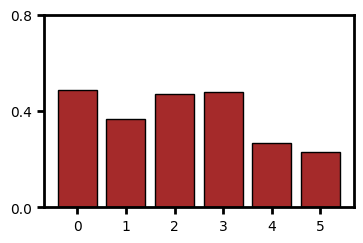

In [ ]:
plt.figure(figsize = [4,2.5])
dim = 0
plt.bar(np.arange(6), np.mean(degree[dim], axis=0), color = 'brown', edgecolor = 'k')
# plt.errorbar(np.arange(6), np.mean(degree[dim], axis=0), np.std(degree[dim], axis=0)/np.sqrt(28), color = 'k', linestyle = '')
plt.yticks([0,0.4,0.8])

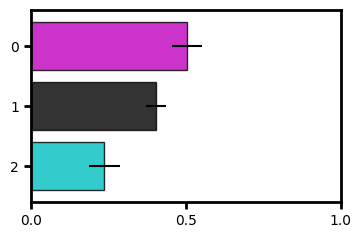

In [ ]:
fig, ax = plt.subplots(figsize = [4,2.5])

dim = 2
dim_corr = np.array([[kendalltau(degree[dim][s], cooccur_degree)[0] for s in range(28)],
                      [kendalltau(degree[dim][s], neuval_degree)[0] for s in range(28)],
                      [kendalltau(degree[dim][s], posval_degree+negval_degree)[0] for s in range(28)]])

ax.barh(np.arange(3), np.mean(dim_corr, axis=1), color = ['m', 'k', 'c'], edgecolor = 'k', alpha = 0.8)
ax.errorbar(np.mean(dim_corr, axis=1), np.arange(3), xerr = np.std(dim_corr, axis=1)/np.sqrt(28), color = 'k', linestyle = '')
ax.vlines(0,-0.6,2.6, linestyle = '--', color = 'grey')
ax.set_ylim([-0.6,2.6])
ax.set_yticks([0,1,2])
ax.set_xticks([0,0.5,1])
ax.invert_yaxis()

In [1713]:
ttest_rel(np.mean(graph_reciprocity_PLS_full, axis=0), np.mean(graph_reciprocity_PLS_valence, axis=0))

TtestResult(statistic=-3.2135728176516647, pvalue=0.0033824704510600047, df=27)

In [1703]:
np.mean(graph_reciprocity_PLS_full, axis=1)

array([0.78552 , 0.804158, 0.784883])

In [1704]:
np.mean(graph_reciprocity_PLS_cooccur, axis=1)

array([0.955921, 0.889619, 0.851402])

In [1705]:
np.mean(graph_reciprocity_PLS_valence, axis=1)

array([0.797195, 0.798995, 0.83373 ])

In [ ]:
# from SRM transformation to reconstruction
from sklearn.metrics import r2_score
multidimensional_from_model = np.array([[srm_full['transformed'][subj][:,sc].reshape(4,30) for sc in range(3)] for subj in range(28)])
# n_dim = [4,2,4]

rs_each_tot = []
r2s_each_tot = []
for v in range(3):
    rs_each = []
    r2s_each = []
    for s in range(28):
        others = np.delete(np.arange(28), s)

        X_train = np.hstack([np.nan_to_num(zscore(multidimensional_from_model[ss][v], axis=1)) for ss in others]).T
        Y_train = np.hstack([np.nan_to_num(zscore(np.array([total_edge_DM[ss][tp][aa] for tp in range(6)]), axis=1)) for ss in others]).T

        X_test = np.nan_to_num(zscore(multidimensional_from_model[s][v], axis=1)).T
        # X_test[:,[0]] = 0
        Y_test = np.nan_to_num(zscore(np.array([total_edge_DM[s][tp][aa] for tp in range(6)]), axis=1)).T

        components = 1

        pls = PLSRegression(n_components=components)
        pls.fit(X_train, Y_train)

        Y_pred = pls.predict(X_test)

        rs_each.append([pearsonr(Y_test[:,rel], Y_pred[:,rel])[0] for rel in range(Y_train.shape[1])])
        r2s_each.append([r2_score(Y_test[:,rel], Y_pred[:,rel]) for rel in range(Y_train.shape[1])])
    rs_each_tot.append(rs_each)
    r2s_each_tot.append(r2s_each)
rs_each_tot = np.array(rs_each_tot)
r2s_each_tot = np.array(r2s_each_tot)

In [1451]:
# rs_each_tot_full = rs_each_tot
# rs_each_tot_valence = rs_each_tot
rs_each_tot_cooccur = rs_each_tot

In [ ]:
rel_corr_full = np.array([[[pearsonr(multidimensional_from_model_mean_full[s][sc] * direction_full[sc], total_edge_DM[s][dim,aa])[0] for dim in range(6)] for sc in range(3)] for s in range(28)])
rel_corr_cooccur = np.array([[[pearsonr(multidimensional_from_model_mean_cooccur[s][sc] * direction_cooccur[sc], total_edge_DM[s][dim,aa])[0] for dim in range(6)] for sc in range(3)] for s in range(28)])
rel_corr_valence = np.array([[[pearsonr(multidimensional_from_model_mean_valence[s][sc] * direction_valence[sc], total_edge_DM[s][dim,aa])[0] for dim in range(6)] for sc in range(3)] for s in range(28)])

In [ ]:
rel_corr = np.array([[[pearsonr(multidimensional_from_model_mean_full[s][sc], total_edge_DM[s][dim,aa])[0] for dim in range(6)] for sc in range(3)] for s in range(28)])
[ttest_1samp(rel_corr[:,sc], 0) for sc in range(3)]

[TtestResult(statistic=array([ 3.150184, -5.481387,  2.6772  ,  3.12831 ,  5.537077,  0.15231 ]), pvalue=array([0.003963, 0.000008, 0.012472, 0.004185, 0.000007, 0.880075]), df=array([27, 27, 27, 27, 27, 27])),
 TtestResult(statistic=array([19.316802, 34.926597, 30.731966, 26.760286, 22.852463, 19.270742]), pvalue=array([0., 0., 0., 0., 0., 0.]), df=array([27, 27, 27, 27, 27, 27])),
 TtestResult(statistic=array([22.62462 , -2.014018, 10.847284, 10.815372, 22.230287, 11.042442]), pvalue=array([0.      , 0.054071, 0.      , 0.      , 0.      , 0.      ]), df=array([27, 27, 27, 27, 27, 27]))]

In [1715]:
[ttest_rel(np.mean(rel_corr_valence, axis=1)[:,dim], np.mean(rel_corr_cooccur, axis=1)[:,dim]) for dim in range(6)]

[TtestResult(statistic=-4.68691365148939, pvalue=7.065243427248481e-05, df=27),
 TtestResult(statistic=7.832002835839311, pvalue=2.01993658081094e-08, df=27),
 TtestResult(statistic=-2.4654448368974613, pvalue=0.02032988261930379, df=27),
 TtestResult(statistic=0.40003392940684224, pvalue=0.6922789316563058, df=27),
 TtestResult(statistic=-5.7084214849243615, pvalue=4.576924539477722e-06, df=27),
 TtestResult(statistic=-1.3630127694095042, pvalue=0.18413843095045038, df=27)]

In [1718]:
[ttest_rel(np.mean(rel_corr_full, axis=1)[:,dim], np.mean(rel_corr_valence, axis=1)[:,dim]) for dim in range(6)]

[TtestResult(statistic=13.957277085355644, pvalue=7.263611343953919e-14, df=27),
 TtestResult(statistic=-1.7022588170197936, pvalue=0.10019516895898845, df=27),
 TtestResult(statistic=10.11663370254261, pvalue=1.1064724118796698e-10, df=27),
 TtestResult(statistic=8.174708472283257, pvalue=8.853526591093057e-09, df=27),
 TtestResult(statistic=14.175859418504068, pvalue=5.012679039401212e-14, df=27),
 TtestResult(statistic=9.5032579564311, pvalue=4.187487597613438e-10, df=27)]

In [1716]:
[ttest_rel(np.mean(rel_corr_full, axis=1)[:,dim], np.mean(rel_corr_cooccur, axis=1)[:,dim]) for dim in range(6)]

[TtestResult(statistic=7.931619335777435, pvalue=1.5868117821417213e-08, df=27),
 TtestResult(statistic=10.228754515322546, pvalue=8.720371990528199e-11, df=27),
 TtestResult(statistic=7.031982147585348, pvalue=1.4686099232899957e-07, df=27),
 TtestResult(statistic=8.094926528503324, pvalue=1.0713091799349809e-08, df=27),
 TtestResult(statistic=4.820956580440208, pvalue=4.928029905558491e-05, df=27),
 TtestResult(statistic=7.024099950495754, pvalue=1.498182465269222e-07, df=27)]

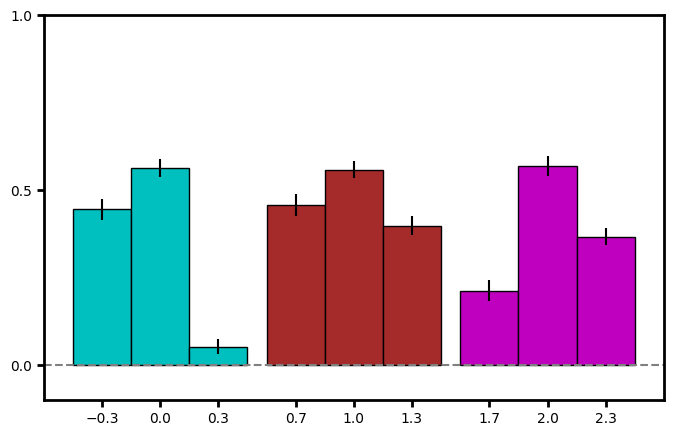

In [ ]:
plt.figure(figsize = [8,5])
dim = 5
# for sc in range(3):
    # plt.bar(np.arange(-0.3,0.4,0.3) + sc, [np.mean(rel_corr_valence, axis=0)[sc][dim], 
    #                                         np.mean(rel_corr_full, axis=0)[sc][dim], 
    #                                         np.mean(rel_corr_cooccur, axis=0)[sc][dim]], 
    #         color = ['c','brown','m'], edgecolor = 'k', width = 0.3)
    
plt.bar(np.arange(-0.3,0.4,0.3), np.mean(rel_corr_valence, axis=0)[:,dim], 
        color = 'c', edgecolor = 'k', width = 0.3)
plt.bar(np.arange(-0.3,0.4,0.3) + 1, np.mean(rel_corr_full, axis=0)[:,dim], 
        color = 'brown', edgecolor = 'k', width = 0.3)
plt.bar(np.arange(-0.3,0.4,0.3) + 2, np.mean(rel_corr_cooccur, axis=0)[:,dim], 
        color = 'm', edgecolor = 'k', width = 0.3)

plt.errorbar(np.arange(-0.3,0.4,0.3), np.mean(rel_corr_valence, axis=0)[:,dim], np.std(rel_corr_valence, axis=0)[:,dim]/np.sqrt(28), 
        color = 'k', linestyle = '')
plt.errorbar(np.arange(-0.3,0.4,0.3) + 1, np.mean(rel_corr_full, axis=0)[:,dim], np.std(rel_corr_full, axis=0)[:,dim]/np.sqrt(28), 
        color = 'k', linestyle = '')
plt.errorbar(np.arange(-0.3,0.4,0.3) + 2, np.mean(rel_corr_cooccur, axis=0)[:,dim], np.std(rel_corr_cooccur, axis=0)[:,dim]/np.sqrt(28), 
        color = 'k', linestyle = '')

# for idx, sc in enumerate([rel_corr_valence, rel_corr_full, rel_corr_cooccur]):
#     plt.scatter(np.random.normal(size = 28)/40 - 0.3 + idx, sc[:,0,dim], color = 'grey', edgecolor = 'k', alpha = 0.3)
#     plt.scatter(np.random.normal(size = 28)/40 + idx, 1-sc[:,1,dim], color = 'grey', edgecolor = 'k', alpha = 0.3)
#     plt.scatter(np.random.normal(size = 28)/40 + 0.3 + idx, sc[:,2,dim], color = 'grey', edgecolor = 'k', alpha = 0.3)

plt.xticks([-0.3,0,0.3,0.7,1,1.3,1.7,2,2.3])
plt.hlines(0, -0.6, 2.6, linestyles='--', color = 'grey')
plt.xlim([-0.6,2.6])
plt.yticks([0,0.5,1])
plt.ylim([-0.1,1])

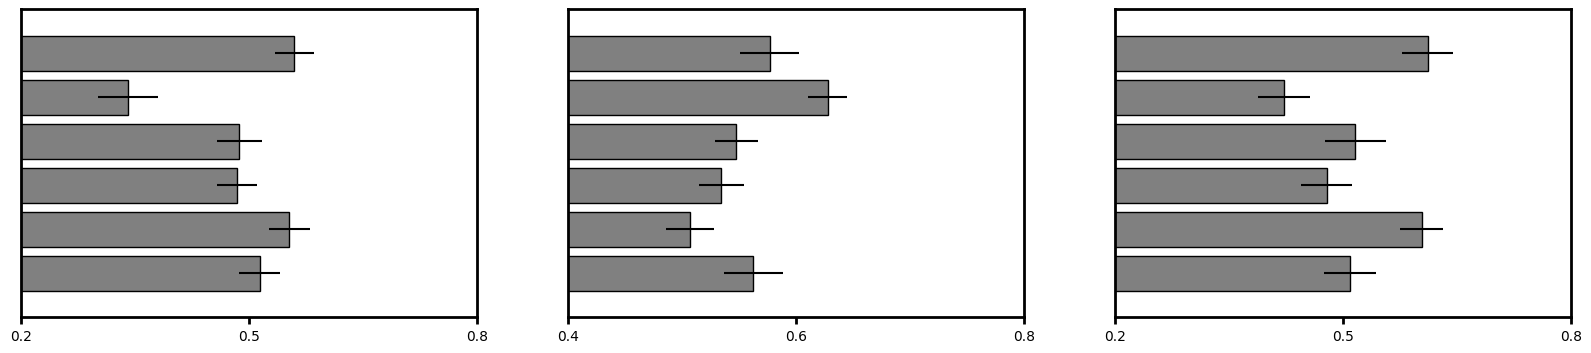

In [ ]:
fig = plt.figure(figsize=(20,4))

# xlim_list = [[-0.2,0.4],[-0.1,0.3],[0.1,0.7]]
xlim_list = [[0.2,0.8],[0.4,0.8],[0.2,0.8]]
xlim_ratio = [0.3,0.2,0.3]

for sc in range(3):
    axs1 = fig.add_subplot(1,3,sc+1)
    means = np.mean(rs_each_tot_full, axis=1)[sc]
    errors = np.std(rs_each_tot_full, axis=1)[sc]/np.sqrt(28)
    axs1.barh(np.arange(6), means, color = 'grey', edgecolor = 'k', zorder = 1)
    axs1.errorbar(means, np.arange(6), xerr = errors, color = 'k', linestyle = '', zorder = 1)
    # for dim in range(6):
    #     axs1.scatter(rel_corr[:,sc,dim], np.random.normal(size = 28)/20 + dim, color = 'k', alpha = 0.2)
    axs1.set_xlim(xlim_list[sc])
    axs1.set_xticks(np.arange(xlim_list[sc][0], xlim_list[sc][1]+0.01, xlim_ratio[sc]))
    axs1.set_ylim([-1,6])
    axs1.set_yticks([])
    axs1.vlines([0],-1,6, 'grey', '--')
    fig.gca().invert_yaxis()
# fig.tight_layout()

In [ ]:
# graph_reciprocity_cooccur = np.array([[calculate_reciprocity(mdf_model[sc][s])[0] for s in range(28)] for sc in range(3)])
graph_reciprocity_full = np.array([[calculate_reciprocity(mdf_model[sc][s])[0] for s in range(28)] for sc in range(3)])
# graph_reciprocity_valence = np.array([[calculate_reciprocity(mdf_model[sc][s])[0] for s in range(28)] for sc in range(3)])

In [93]:
np.mean(graph_reciprocity_full, axis=1)

array([0.908671, 0.795927, 0.832001])

In [160]:
np.mean(graph_reciprocity_cooccur, axis=1)

array([0.903396, 0.796102, 0.808509])

In [165]:
np.mean(graph_reciprocity_valence, axis=1)

array([0.875061, 0.801257, 0.871135])

In [190]:
[ttest_rel(graph_reciprocity_cooccur[sc], graph_reciprocity_valence[sc]) for sc in range(3)]

[TtestResult(statistic=14.69394777425927, pvalue=2.117467665086604e-14, df=27),
 TtestResult(statistic=8.194652660774976, pvalue=8.442571502838891e-09, df=27),
 TtestResult(statistic=7.35135572273265, pvalue=6.588926660347073e-08, df=27)]

In [161]:
[ttest_rel(graph_reciprocity_full[sc1], graph_reciprocity_full[sc2]) for sc1, sc2 in [[0,1],[1,2],[0,2]]]

[TtestResult(statistic=9.329133230144835, pvalue=6.164353944868714e-10, df=27),
 TtestResult(statistic=-2.6438195112329046, pvalue=0.013486087035592495, df=27),
 TtestResult(statistic=9.371284222136302, pvalue=5.611481147483436e-10, df=27)]

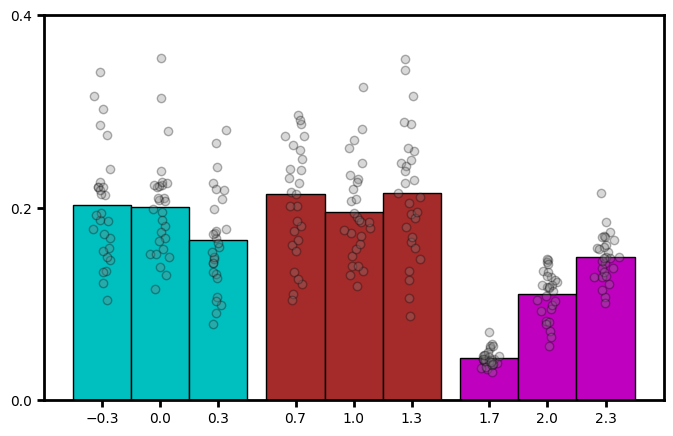

In [ ]:
plt.figure(figsize = [8,5])
plt.bar(np.arange(-0.3,0.4,0.3), np.mean(1-graph_reciprocity_PLS_valence, axis=1), color = 'c', edgecolor = 'k', width = 0.3)
plt.bar(np.arange(-0.3,0.4,0.3)+1, np.mean(1-graph_reciprocity_PLS, axis=1), color = 'brown', edgecolor = 'k', width = 0.3)
plt.bar(np.arange(-0.3,0.4,0.3)+2, np.mean(1-graph_reciprocity_PLS_cooccur, axis=1), color = 'm', edgecolor = 'k', width = 0.3)
for idx, sc in enumerate([graph_reciprocity_PLS_valence, graph_reciprocity_PLS, graph_reciprocity_PLS_cooccur]):
    plt.scatter(np.random.normal(size = 28)/40 - 0.3 + idx, 1-sc[0], color = 'grey', edgecolor = 'k', alpha = 0.3)
    plt.scatter(np.random.normal(size = 28)/40 + idx, 1-sc[1], color = 'grey', edgecolor = 'k', alpha = 0.3)
    plt.scatter(np.random.normal(size = 28)/40 + 0.3 + idx, 1-sc[2], color = 'grey', edgecolor = 'k', alpha = 0.3)
plt.xticks([-0.3,0,0.3,0.7,1,1.3,1.7,2,2.3])
plt.yticks([0,0.2,0.4])
plt.xlim([-0.6,2.6])
plt.ylim([0.0,0.4])

### Predicting personality traits

In [ ]:
torch.manual_seed(2022)
np.random.seed(2022) # random seed setting

backend = set_backend("torch_cuda", on_error="warn")
feature_names = ["a", "b", "c"]

n_iter = 20
alphas = np.logspace(-3, 3, 20)

n_targets_batch = 200
n_alphas_batch = 10
n_targets_batch_refit = 100

fold = np.array([[0,1,2,3,4,5,6],[7,8,9,10,11,12,13],[14,15,16,17,18,19,20],[21,22,23,24,25,26,27]])
us = [0,1,2]
        
r0 = []
r1 = []
r2 = []
r3 = []
weights = []
for p_num in range(7):
    r_scores_batch0 = []
    r_scores_batch1 = []
    r_scores_batch2 = []
    r_scores_batch3 = []
    weight = []
    for cv_fold in range(4):
        train_fold = np.delete(np.arange(4), cv_fold)
        train = np.concatenate([fold[c] for c in train_fold])
        test = fold[cv_fold]

        outdegree_tf = np.hstack([zscore(outdegree[us,sub], axis=1) for sub in train])
        indegree_tf = np.hstack([zscore(indegree[us,sub], axis=1) for sub in train])
        node_reciprocity_tf = np.hstack([zscore(node_reciprocity[us,sub], axis=1) for sub in train])
        inout_ratio_tf = np.hstack([zscore(inout_ratio[us,sub], axis=1) for sub in train])
        local_clustering_tf = np.hstack([zscore(local_clustering[us,sub], axis=1) for sub in train])
        X_train = np.vstack([[outdegree_tf[sc], indegree_tf[sc], node_reciprocity_tf[sc], inout_ratio_tf[sc], local_clustering_tf[sc]] for sc in range(3)]).T

        personality = np.nan_to_num(np.vstack([zscore(total_personalities[sub][2], axis=0) for sub in train]))
        Y_train = personality[:, p_num, None]

        outdegree_tf = np.hstack([zscore(outdegree[us,sub], axis=1) for sub in test])
        indegree_tf = np.hstack([zscore(indegree[us,sub], axis=1) for sub in test])
        node_reciprocity_tf = np.hstack([zscore(node_reciprocity[us,sub], axis=1) for sub in test])
        inout_ratio_tf = np.hstack([zscore(inout_ratio[us,sub], axis=1) for sub in test])
        local_clustering_tf = np.hstack([zscore(local_clustering[us,sub], axis=1) for sub in test])
        X_test = np.vstack([[outdegree_tf[sc], indegree_tf[sc], node_reciprocity_tf[sc], inout_ratio_tf[sc], local_clustering_tf[sc]] for sc in range(3)]).T

        personality = np.nan_to_num(np.vstack([zscore(total_personalities[sub][2], axis=0) for sub in test]))
        Y_test = personality[:, p_num, None]

        n_features_list = [5, 5, 5]
        n_features_list_cumsum = np.cumsum([0] + n_features_list)
        
        X_train = X_train.astype("float32")
        X_test = X_test.astype("float32")
        Y_train = Y_train.astype("float32")
        Y_test = Y_test.astype("float32")

        solver = "random_search"
        solver_function = GroupRidgeCV.ALL_SOLVERS[solver]

        n_samples_train = X_train.shape[0]
        cv = generate_leave_one_run_out(n_samples_train, n_features_list_cumsum[:-1])
        cv = check_cv(cv)

        solver_params = dict(n_iter=n_iter, alphas=alphas, n_targets_batch=n_targets_batch, 
                             n_alphas_batch=n_alphas_batch, n_targets_batch_refit=n_targets_batch_refit)
        
        mkr_model = GroupRidgeCV(groups="input", solver=solver, solver_params=solver_params, cv=cv)

        preprocess_pipeline = make_pipeline(StandardScaler(with_mean=True, with_std=False), Delayer(delays=[0]))

        start_and_end = np.concatenate([[0], np.cumsum(n_features_list)])
        slices = [slice(start, end) for start, end in zip(start_and_end[:-1], start_and_end[1:])]

        kernelizers_tuples = [(name, preprocess_pipeline, slice_) for name, slice_ in zip(feature_names, slices)]
        column_kernelizer = ColumnTransformerNoStack(kernelizers_tuples)

        pipeline = make_pipeline(column_kernelizer, mkr_model)
        pipeline.fit(X_train, Y_train)    

        y_test_pred_split = pipeline.predict(X_test, split=True)    
        pred_y = pipeline.predict(X_test)
        pred_y = backend.to_numpy(pred_y)
        split_rscores = correlation_score_split(Y_test, y_test_pred_split)
        
        r_scores_batch0.append(fisher_r_to_z(backend.to_numpy(correlation_score(Y_test, pred_y))))
        r_scores_batch1.append(fisher_r_to_z(backend.to_numpy(split_rscores[0])))
        r_scores_batch2.append(fisher_r_to_z(backend.to_numpy(split_rscores[1])))
        r_scores_batch3.append(fisher_r_to_z(backend.to_numpy(split_rscores[2])))
        weight.append(backend.to_numpy(pipeline.named_steps['groupridgecv'].coef_))
        torch.cuda.empty_cache()
    r0.append(np.mean(r_scores_batch0))
    r1.append(np.mean(r_scores_batch1))
    r2.append(np.mean(r_scores_batch2))
    r3.append(np.mean(r_scores_batch3))
    weights.append(np.mean(weight, axis=0))

r0_true = np.array(r0)
r1_true = np.array(r1)
r2_true = np.array(r2)
r3_true = np.array(r3)
weight_true = np.array(weights)

In [ ]:
torch.manual_seed(2022)
np.random.seed(2022) # random seed setting

r0s = []
r1s = []
r2s = []
r3s = []
for repeat in range(1000):
    r0 = []
    r1 = []
    r2 = []
    r3 = []
    for p_num in range(7):
        r_scores_batch0 = []
        r_scores_batch1 = []
        r_scores_batch2 = []
        r_scores_batch3 = []
        for cv_fold in range(4):
            train_fold = np.delete(np.arange(4), cv_fold)
            train = np.concatenate([fold[c] for c in train_fold])
            test = fold[cv_fold]

            outdegree_tf = np.hstack([zscore(outdegree[us,sub], axis=1) for sub in train])
            indegree_tf = np.hstack([zscore(indegree[us,sub], axis=1) for sub in train])
            node_reciprocity_tf = np.hstack([zscore(node_reciprocity[us,sub], axis=1) for sub in train])
            inout_ratio_tf = np.hstack([zscore(inout_ratio[us,sub], axis=1) for sub in train])
            local_clustering_tf = np.hstack([zscore(local_clustering[us,sub], axis=1) for sub in train])
            X_train = np.vstack([[outdegree_tf[sc], indegree_tf[sc], node_reciprocity_tf[sc], inout_ratio_tf[sc], local_clustering_tf[sc]] for sc in range(3)]).T

            personality = np.nan_to_num(np.vstack([zscore(total_personalities[sub][2][np.random.permutation(6)], axis=0) for sub in train]))
            Y_train = personality[:, p_num, None]

            outdegree_tf = np.hstack([zscore(outdegree[us,sub], axis=1) for sub in test])
            indegree_tf = np.hstack([zscore(indegree[us,sub], axis=1) for sub in test])
            node_reciprocity_tf = np.hstack([zscore(node_reciprocity[us,sub], axis=1) for sub in test])
            inout_ratio_tf = np.hstack([zscore(inout_ratio[us,sub], axis=1) for sub in test])
            local_clustering_tf = np.hstack([zscore(local_clustering[us,sub], axis=1) for sub in test])
            X_test = np.vstack([[outdegree_tf[sc], indegree_tf[sc], node_reciprocity_tf[sc], inout_ratio_tf[sc], local_clustering_tf[sc]] for sc in range(3)]).T

            personality = np.nan_to_num(np.vstack([zscore(total_personalities[sub][2][np.random.permutation(6)], axis=0) for sub in test]))
            Y_test = personality[:, p_num, None]

            n_features_list = [5, 5, 5]
            n_features_list_cumsum = np.cumsum([0] + n_features_list)
            
            X_train = X_train.astype("float32")
            X_test = X_test.astype("float32")
            Y_train = Y_train.astype("float32")
            Y_test = Y_test.astype("float32")

            solver = "random_search"
            solver_function = GroupRidgeCV.ALL_SOLVERS[solver]

            n_samples_train = X_train.shape[0]
            cv = generate_leave_one_run_out(n_samples_train, n_features_list_cumsum[:-1])
            cv = check_cv(cv)

            solver_params = dict(n_iter=n_iter, alphas=alphas, n_targets_batch=n_targets_batch, 
                                n_alphas_batch=n_alphas_batch, n_targets_batch_refit=n_targets_batch_refit)
            
            mkr_model = GroupRidgeCV(groups="input", solver=solver, solver_params=solver_params, cv=cv)

            preprocess_pipeline = make_pipeline(StandardScaler(with_mean=True, with_std=False), Delayer(delays=[0]))

            start_and_end = np.concatenate([[0], np.cumsum(n_features_list)])
            slices = [slice(start, end) for start, end in zip(start_and_end[:-1], start_and_end[1:])]

            kernelizers_tuples = [(name, preprocess_pipeline, slice_) for name, slice_ in zip(feature_names, slices)]
            column_kernelizer = ColumnTransformerNoStack(kernelizers_tuples)

            pipeline = make_pipeline(column_kernelizer, mkr_model)
            pipeline.fit(X_train, Y_train)    

            y_test_pred_split = pipeline.predict(X_test, split=True)    
            pred_y = pipeline.predict(X_test)
            pred_y = backend.to_numpy(pred_y)
            split_rscores = correlation_score_split(Y_test, y_test_pred_split)
            
            r_scores_batch0.append(fisher_r_to_z(backend.to_numpy(correlation_score(Y_test, pred_y))))
            r_scores_batch1.append(fisher_r_to_z(backend.to_numpy(split_rscores[0])))
            r_scores_batch2.append(fisher_r_to_z(backend.to_numpy(split_rscores[1])))
            r_scores_batch3.append(fisher_r_to_z(backend.to_numpy(split_rscores[2])))
            torch.cuda.empty_cache()
        r0.append(np.mean(r_scores_batch0))
        r1.append(np.mean(r_scores_batch1))
        r2.append(np.mean(r_scores_batch2))
        r3.append(np.mean(r_scores_batch3))
    r0s.append(r0)
    r1s.append(r1)
    r2s.append(r2)
    r3s.append(r3)
r0s_perm = np.array(r0s)
r1s_perm = np.array(r1s)
r2s_perm = np.array(r2s)
r3s_perm = np.array(r3s)

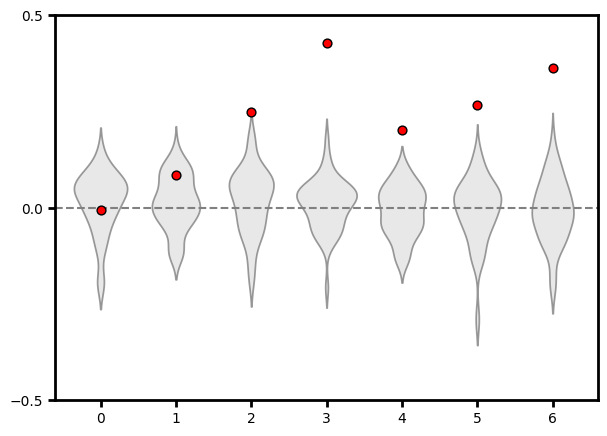

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(7, 5))

sns.violinplot(data=r0s_perm, inner=None, cut=2, color="lightgray", ax=ax, alpha = 0.5)
percentiles = np.percentile(r0s_perm, 95, axis=0)
# ax.hlines(percentiles, xmin=np.arange(len(r2s_true)) - 0.3, xmax=np.arange(len(r2s_true)) + 0.3,
#           colors="grey", linestyles="--", label="95th percentile")
ax.hlines(0, xmin=-0.6, xmax=6.6, colors="grey", linestyles="--")
ax.set_xlim([-0.6,6.6])
ax.set_ylim([-0.5,0.5])
ax.set_yticks([-0.5,0,0.5])
ax.scatter(np.arange(len(r0_true)), r0_true, color="red", s=40, zorder=3, label="True", edgecolor = 'k')

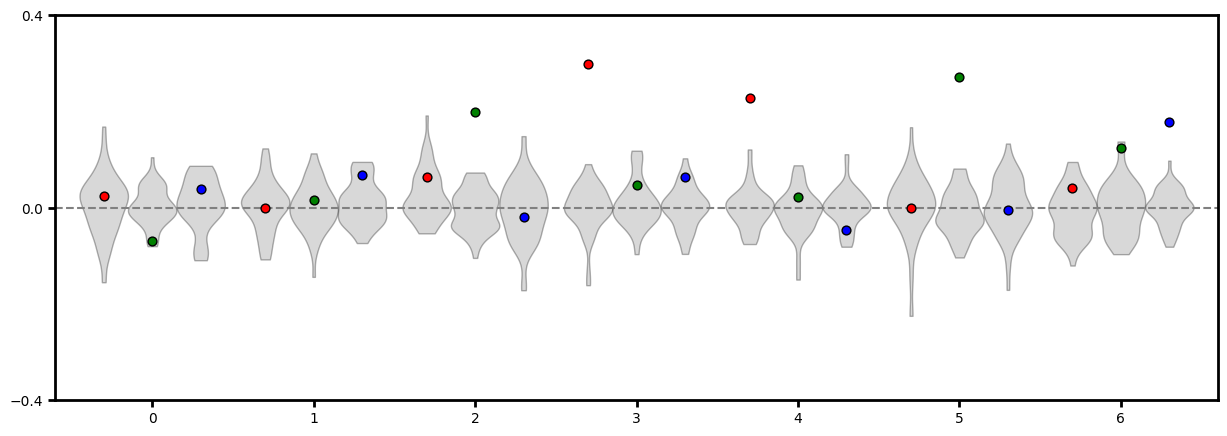

In [ ]:
fig, ax = plt.subplots(figsize = [15, 5])
rs_true = [r1_true, r2_true, r3_true]
rs_perm = [r1s_perm, r2s_perm, r3s_perm]
pos = [-0.3, 0, 0.3]
colors = ['r','g','b']
for fs in range(3):
    vp = ax.violinplot(rs_perm[fs], positions = np.arange(7) + pos[fs], showmeans=False,showmedians=False, showextrema=False, widths = 0.3)
    ax.scatter(np.arange(len(r0_true)) + pos[fs], rs_true[fs], color=colors[fs], s=40, zorder=3, label="True", edgecolor = 'k')

    for body in vp['bodies']:
        body.set_facecolor('grey')
        body.set_edgecolor('black')
        body.set_alpha(0.3)
ax.hlines(0, xmin=-0.6, xmax=6.6, colors="grey", linestyles="--")
ax.set_xlim([-0.6,6.6])
ax.set_ylim([-0.4,0.4])
ax.set_yticks([-0.4,0,0.4])
plt.show()